###Convolutional Neural Network

In [ ]:
pip install fastai -U

In [ ]:
pip install nbdev

In [ ]:
from google.colab import files
files.upload()

{}

In [ ]:
from fastai.vision.all import *
matplotlib.rc('image', cmap='Greys')

In [ ]:
top_edge = tensor([-1, -1, -1],
                  [ 0,  0,  0],
                  [ 1,  1,  1]).float()

In [ ]:
path = untar_data(URLs.MNIST_SAMPLE)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#3) [Path('train'),Path('valid'),Path('labels.csv')]

In [ ]:
(path/'train/3').ls()

(#6131) [Path('train/3/58785.png'),Path('train/3/23877.png'),Path('train/3/3674.png'),Path('train/3/12877.png'),Path('train/3/14350.png'),Path('train/3/28757.png'),Path('train/3/46595.png'),Path('train/3/27783.png'),Path('train/3/22733.png'),Path('train/3/35381.png')...]

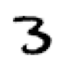

In [ ]:
# Getting one image
img3 = Image.open(path / 'train'/'3'/'12.png')
show_image(img3);

In [ ]:
## Taking 3X3 pixel square of 3 and adding it with the kernel

im3_t = tensor(img3)
im3_t[0:3, 0:3] * top_edge

tensor([[-0., -0., -0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
im3_t.shape

torch.Size([28, 28])

In [ ]:
(im3_t[0:3, 0:3] * top_edge).sum()

tensor(0.)

In [ ]:
## Looking at the image pixels

df = pd.DataFrame(im3_t[:10, :20])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,12,99,91,142,155,246,182,155,155,155,155,131,52,0,0,0,0
6,0,0,0,138,254,254,254,254,254,254,254,254,254,254,254,252,210,122,33,0
7,0,0,0,220,254,254,254,235,189,189,189,189,150,189,205,254,254,254,75,0
8,0,0,0,35,74,35,35,25,0,0,0,0,0,0,13,224,254,254,153,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,90,254,254,247,53,0


In [ ]:
## Taking a section where there are numbers

(im3_t[4:7, 6:9] * top_edge).sum()

tensor(762.)

In [ ]:
## Another section

(im3_t[7:10, 17:20] * top_edge).sum()

tensor(-29.)

In [ ]:
#Creating a function that does the kernel computation

def apply_kernel(row, col, kernel):
    return (im3_t[row - 1:row + 2, col - 1:col + 2] * kernel).sum()

In [ ]:
## Mapping Convolution filter

[(i, j) for j in range(1, 5) for i in range(6, 10)]

[(6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (6, 2),
 (7, 2),
 (8, 2),
 (9, 2),
 (6, 3),
 (7, 3),
 (8, 3),
 (9, 3),
 (6, 4),
 (7, 4),
 (8, 4),
 (9, 4)]

In [ ]:
[[(i, j) for j in range(1, 5)] for i in range(1, 5)]

[[(1, 1), (1, 2), (1, 3), (1, 4)],
 [(2, 1), (2, 2), (2, 3), (2, 4)],
 [(3, 1), (3, 2), (3, 3), (3, 4)],
 [(4, 1), (4, 2), (4, 3), (4, 4)]]

torch.Size([26, 26])

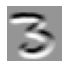

In [ ]:
# Detecting the top edge
rng = range(1, 27)
top_edge3 = tensor([[apply_kernel(i, j, top_edge) for j in rng] for i in rng])

show_image(top_edge3); top_edge3.shape

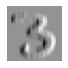

In [ ]:
## Detecting the left edge

left_edge = tensor([[-1, 1, 0],
                    [-1, 1, 0],
                    [-1, 1, 0]]).float()

left_edge3 = tensor([[apply_kernel(i, j, left_edge) for j in rng] for i in rng])
show_image(left_edge3);

In [ ]:
## Convolutions in PyTorch

diag1_edge = tensor([[0, -1, 1],
                     [-1, 1, 0],
                     [1, 0, 0]]).float()
diag2_edge = tensor([[1, -1, 0],
                     [0, 1, -1],
                     [0, 0, 1]]).float()

edge_kernels = torch.stack([left_edge, top_edge, diag1_edge, diag2_edge])
edge_kernels.shape

torch.Size([4, 3, 3])

In [ ]:
## To test this out we will need Dataloader and a simple mini-batch

mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
                  get_items=get_image_files,
                  splitter=GrandparentSplitter(),
                  get_y=parent_label)

dls = mnist.dataloaders(path)
xb, yb = first(dls.valid)
xb.shape

torch.Size([64, 1, 28, 28])

In [ ]:
# By default fastai puts data on GPU. Lets put it on CPU

xb, yb = to_cpu(xb), to_cpu(yb)

In [ ]:
edge_kernels.shape, edge_kernels.unsqueeze_(1).shape

(torch.Size([4, 3, 3]), torch.Size([4, 1, 3, 3]))

In [ ]:
edge_kernels.shape

torch.Size([4, 1, 3, 3])

In [ ]:
### now that we have the features lined up let's pass it on to conv2d

batch_features = F.conv2d(xb, edge_kernels)
batch_features.shape

torch.Size([64, 4, 26, 26])

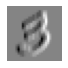

In [ ]:
show_image(batch_features[3,0]);

In [ ]:
## Creating a CNN
## Let's look at typical nn
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [ ]:
simple_net

Sequential(
  (0): Linear(in_features=784, out_features=30, bias=True)
  (1): ReLU()
  (2): Linear(in_features=30, out_features=1, bias=True)
)

In [ ]:
## nn.Conv2d is identical to F.Conv2d and creates the weight matrix for us

broken_cnn = sequential(
    nn.Conv2d(1, 30, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(30, 1, kernel_size=3, padding=1)
)

In [ ]:
broken_cnn

Sequential(
  (0): Conv2d(1, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(30, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [ ]:
broken_cnn(xb).shape

torch.Size([64, 1, 28, 28])

In [ ]:
## We cannot do classsification what those dimensions so we need to make some changes

def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, nn.ReLU())
    return res

In [ ]:
## simple cnn

simple_cnn = sequential(
    conv(1, 4),                 #14X14
    conv(4, 8),                 #7X7
    conv(8, 16),                #4X4
    conv(16, 32),               #2X2
    conv(32, 2, act=False),     #1X1
    Flatten(),
)

In [ ]:
simple_cnn(xb).shape

torch.Size([64, 2])

In [ ]:
learn = Learner(dls, simple_cnn, loss_func=F.cross_entropy, metrics=accuracy)

In [ ]:
learn.summary()

Sequential (Input shape: ['64 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 4 x 14 x 14     40         True      
________________________________________________________________
ReLU                 64 x 4 x 14 x 14     0          False     
________________________________________________________________
Conv2d               64 x 8 x 7 x 7       296        True      
________________________________________________________________
ReLU                 64 x 8 x 7 x 7       0          False     
________________________________________________________________
Conv2d               64 x 16 x 4 x 4      1,168      True      
________________________________________________________________
ReLU                 64 x 16 x 4 x 4      0          False     
________________________________________________________________
Conv2d               64 x 32 x 2 x 2      4,640      True      
___________________________________________________

In [ ]:
learn.fit_one_cycle(2, 0.01)

epoch,train_loss,valid_loss,accuracy,time
0,0.080688,0.040215,0.989696,00:12
1,0.031498,0.030111,0.990186,00:12


In [ ]:
## Understanding COnvolution arithmetic

m = learn.model[0]
m

Sequential(
  (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): ReLU()
)

In [ ]:
# Let's check the weights of the first convolution

m[0].weight.shape

torch.Size([4, 1, 3, 3])

In [ ]:
m[0].bias.shape

torch.Size([4])

In [ ]:
### Let's look at color images

im = image2tensor(Image.open('/content/Screen Shot 2020-09-17 at 3.27.23 PM.png'))
im.shape

FileNotFoundError: ignored

In [ ]:
show_image(im);

In [ ]:
## Color image is a rank three tensor. First rank contains the color channels

_,axs = subplots(1, 3)
for bear, ax, color in zip(im, axs, ('Reds', 'Greens', 'Blues')):
    show_image(255-bear, ax=ax, cmap=color)

In [ ]:
## Recognizing all 10 digits

path = untar_data(URLs.MNIST)

In [ ]:
Path.BASE_PATH = path

In [ ]:
path.ls()

(#2) [Path('training'),Path('testing')]

In [ ]:
# Creating a function that gets different batch sizes

def get_dls(bs=64):
    return DataBlock(
        blocks=(ImageBlock(cls=PILImageBW), CategoryBlock),
        get_items = get_image_files,
        get_y=parent_label,
        batch_tfms=Normalize(),
        splitter=GrandparentSplitter('training', 'testing')
    ).dataloaders(path, bs=bs)

dls = get_dls()

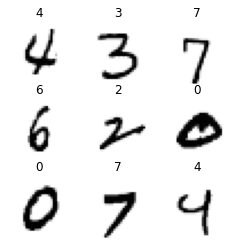

In [ ]:
dls.show_batch(max_n=9, nrows=3, figsize=(4,4))

In [ ]:
## basic convolution layer

def conv(ni, nf, ks=3, act=True):
    res = nn.Conv2d(ni, nf, kernel_size=ks, stride=2, padding=ks//2)
    if act: res = nn.Sequential(
        res,
        nn.ReLU())
    return res

In [ ]:
def simple_cnn():
    return sequential(
        conv(1, 8, ks=5),           #14x14
        conv(8, 16),                #7x7
        conv(16, 32),               #4x4
        conv(32, 64),               #2x2
        conv(64, 10, act=False),    #1x1
        Flatten()
    )

In [123]:
learn.summary()

Sequential (Input shape: ['512 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               512 x 8 x 14 x 14    208        True      
________________________________________________________________
ReLU                 512 x 8 x 14 x 14    0          False     
________________________________________________________________
Conv2d               512 x 16 x 7 x 7     1,168      True      
________________________________________________________________
ReLU                 512 x 16 x 7 x 7     0          False     
________________________________________________________________
Conv2d               512 x 32 x 4 x 4     4,640      True      
________________________________________________________________
ReLU                 512 x 32 x 4 x 4     0          False     
________________________________________________________________
Conv2d               512 x 64 x 2 x 2     18,496     True      
__________________________________________________

In [ ]:
from fastai.callback.hook import *

In [ ]:
def fit(epoch=1):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit(epoch, 0.06)
    return learn

In [ ]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.308383,2.304587,0.113500,01:02


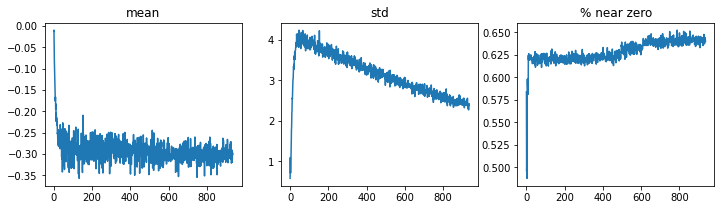

In [ ]:
learn.activation_stats.plot_layer_stats(0)

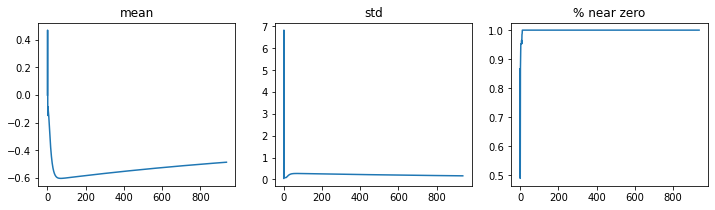

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

In [103]:
dls = get_dls(512)

In [104]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,2.308746,2.302470,0.101000,00:53


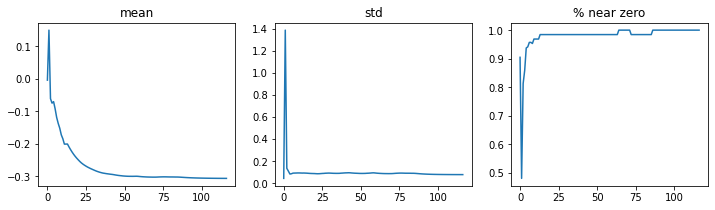

In [105]:
learn.activation_stats.plot_layer_stats(-2)

In [106]:
## Using one cycle training: Variable learning rate

def fit(epoch=1, lr=0.06):
    learn = Learner(dls, simple_cnn(), loss_func=F.cross_entropy,
                    metrics=accuracy, cbs=ActivationStats(with_hist=True))
    learn.fit_one_cycle(epoch, lr)
    return learn

In [107]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.208653,0.074645,0.978500,00:52


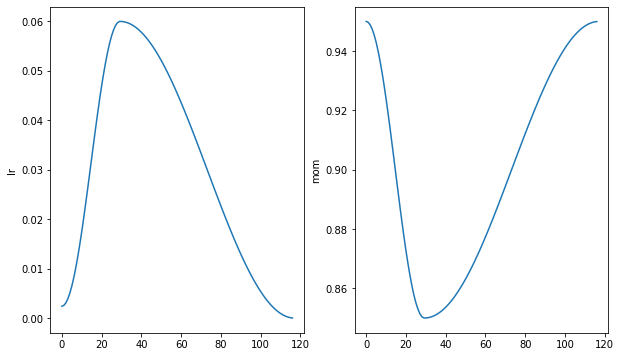

In [115]:
learn.recorder.plot_sched(figsize=(10,6))

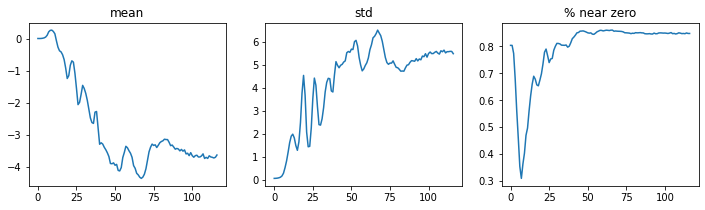

In [116]:
learn.activation_stats.plot_layer_stats(-2)

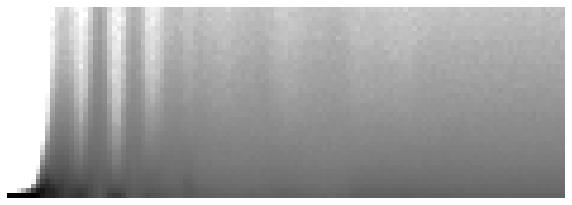

In [117]:
learn.activation_stats.color_dim(-2)

In [134]:
# Batch Norm
def conv(ni, nf, ks=3, act=True):
    layers = [nn.Conv2d(ni, nf, stride=2, kernel_size=ks, padding=ks//2)]
    layers.append(nn.BatchNorm2d(nf))
    if act: layers.append(nn.ReLU())
    return nn.Sequential(*layers)

In [142]:
learn = fit()

epoch,train_loss,valid_loss,accuracy,time
0,0.135334,0.057704,0.984800,00:54


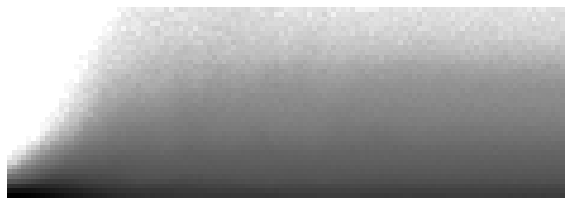

In [143]:
learn.activation_stats.color_dim(-4)

In [144]:
learn = fit(5, lr=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.186686,0.089707,0.972400,00:54
1,0.075100,0.072927,0.975900,00:54
2,0.052085,0.039856,0.987300,00:54
3,0.031667,0.031180,0.989900,00:55
4,0.016357,0.025753,0.990900,00:55
